## DNSC 6279 Spring 2019 Assignment 4
## Group 6 -- Yixuan Huang, Ada Li, Xinyu Wang, Jingsi Wu
#### In this assignment we will use the training data from assignment 3 to build a reasonable number of customer clusters. We will use principal components analysis (PCA) to explore the data and confirm our results. We will use k-means clustering to make our clusters.
 

In [1]:
import h2o 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
import pandas as pd
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.kmeans import H2OKMeansEstimator
from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator

In [2]:
# read data 
train_pd = pd.read_csv('assign_05_train.csv')

In [3]:
# start h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\Users\Administrator\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMINI~1\AppData\Local\Temp\tmpd6evwlzy
  JVM stdout: C:\Users\ADMINI~1\AppData\Local\Temp\tmpd6evwlzy\h2o_Administrator_started_from_python.out
  JVM stderr: C:\Users\ADMINI~1\AppData\Local\Temp\tmpd6evwlzy\h2o_Administrator_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,1 month and 2 days
H2O cluster name:,H2O_from_python_Administrator_kdnosz
H2O cluster total nodes:,1
H2O cluster free memory:,5.314 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [4]:
# enforce same measurement levels in h2o and pandas
col_types = {'chain': 'enum',
             'offer': 'enum',
             'market': 'enum',
             'category': 'enum',
             'company': 'enum',
             'brand': 'enum',
             'exact_item_bought': 'enum',
             'month': 'enum',
             'week': 'enum'}

frame = h2o.H2OFrame(train_pd, column_types=col_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
frame.describe()

Rows:64122
Cols:18




,id,chain,offer,market,repeater,offerdate,category,quantity,company,offervalue,brand,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,dayOfWeek,day
type,int,enum,enum,enum,int,int,enum,int,enum,real,enum,real,real,enum,enum,enum,enum,int
mins,86246.0,,,,0.0,1362096000000.0,,1.0,,0.75,,-1.0,-85.14,,,,,1.0
mean,1865046990.705777,,,,0.2693771248557437,1365226057677.5579,,1.0,,1.255356975764942,,0.6942286652420018,2.2440281205381436,,,,,19.029849349677097
maxs,4809911000.0,,,,1.0,1367280000000.0,,1.0,,3.0,,44.181818182,60.802,,,,,31.0
sigma,1567329467.9984725,,,,0.4436396723261261,1304850779.386149,,0.0,,0.5238038613432835,,0.7714497289290286,2.6319680001789507,,,,,9.628506814875884
zeros,0,,,,46849,0,,0,,0,,29124,29138,,,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,86246.0,205,1208251,34,1.0,1366761600000.0,2202,1.0,104460040,2.0,3718,0.0,0.0,0,4,17,Wed,24.0
1,12682470.0,18,unknown,11,0.0,1364428800000.0,unknown,1.0,unknown,0.75,unknown,1.0,2.5,1,3,13,Thu,28.0
2,13807224.0,4,1204576,1,0.0,1365120000000.0,5616,1.0,104610040,1.0,15889,1.4375,3.365,1,4,14,Fri,5.0


In [6]:
# set modeling roles
y = 'repeater'
X = ['offervalue','avg_category_quantity','avg_category_amount','exact_item_bought','month','week','day']
print(y)
print(X)

repeater
['offervalue', 'avg_category_quantity', 'avg_category_amount', 'exact_item_bought', 'month', 'week', 'day']


## Removing outliers:

In [7]:
# project training data onto 3-D using principal components and print the head
pca = H2OPrincipalComponentAnalysisEstimator(transform='standardize',seed=12345,k=3) # project onto 3 PCs
pca.train(x=X, training_frame=frame)
features = pca.predict(frame)
features_pandas = features.as_data_frame()
print(features_pandas.head())


pca Model Build progress: |███████████████████████████████████████████████| 100%


C:\Users\Administrator\Anaconda3\lib\site-packages\h2o\job.py:69: UserWarning: _train: Dataset used may contain fewer number of rows due to removal of rows with NA/missing values.  If this is not desirable, set impute_missing argument in pca call to TRUE/True/true/... depending on the client language.
  warnings.warn(w)


pca prediction progress: |████████████████████████████████████████████████| 100%
        PC1       PC2       PC3
0  1.148992  0.259361  1.891686
1 -0.512041  0.997286 -0.917864
2 -1.938982 -1.370536  0.177618
3  0.224752 -2.263205 -0.225601
4  0.173512 -2.438949 -0.213482


## Figure 1: The first three principal components of the training data with outliers.

<IPython.core.display.Javascript object>


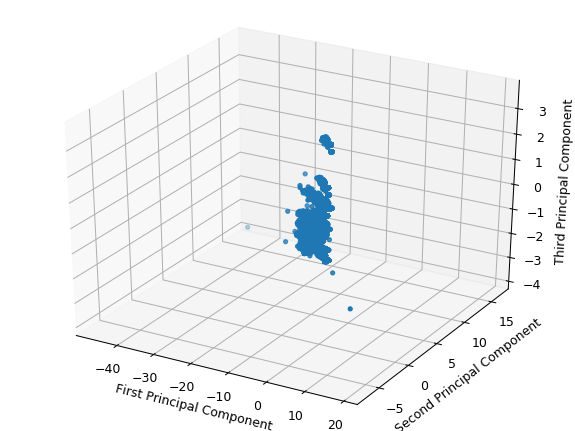

Text(0.5, 0, 'Third Principal Component')

In [8]:
#plot 
%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs=features_pandas.PC1,ys=features_pandas.PC2,zs=features_pandas.PC3,s=10)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

In [9]:
#finding the outliers
features_pandas[(features_pandas['PC1'] <-40)|(features_pandas['PC1'] > 10)]

,PC1,PC2,PC3
2903,18.688765,-6.892467,-1.009567
21276,-46.475067,16.516525,-3.785917


In [10]:
outlier_idx = [2903, 21276]

In [11]:
# drop outliers
frame_new =frame.drop(outlier_idx,axis=0)

In [12]:
frame_new.describe()

Rows:64120
Cols:18




,id,chain,offer,market,repeater,offerdate,category,quantity,company,offervalue,brand,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,dayOfWeek,day
type,int,enum,enum,enum,int,int,enum,int,enum,real,enum,real,real,enum,enum,enum,enum,int
mins,86246.0,,,,0.0,1362096000000.0,,1.0,,0.75,,-1.0,-26.75,,,,,1.0
mean,1865093494.2664864,,,,0.269369931378665,1365226052900.8184,,1.0,,1.2553688396756113,,0.6935300788282264,2.2446085147119152,,,,,19.029709918902114
maxs,4809911000.0,,,,1.0,1367280000000.0,,1.0,,3.0,,16.565217390999994,60.802,,,,,31.0
sigma,1567331419.1788533,,,,0.44363593282459335,1304853361.6844783,,0.0,,0.5238072576965788,,0.752084750167868,2.601754496292617,,,,,9.628620968186755
zeros,0,,,,46848,0,,0,,0,,29124,29138,,,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,86246.0,205,1208251,34,1.0,1366761600000.0,2202,1.0,104460040,2.0,3718,0.0,0.0,0,4,17,Wed,24.0
1,12682470.0,18,unknown,11,0.0,1364428800000.0,unknown,1.0,unknown,0.75,unknown,1.0,2.5,1,3,13,Thu,28.0
2,13807224.0,4,1204576,1,0.0,1365120000000.0,5616,1.0,104610040,1.0,15889,1.4375,3.365,1,4,14,Fri,5.0


In [13]:
#Confirm that the outliers have been removed by retraining and re-plotting the first 3 principal components of the filtered training data
pca_new = H2OPrincipalComponentAnalysisEstimator(transform='standardize',seed=12345,k=3) 
pca_new.train(x=X, training_frame=frame_new)
features_new = pca_new.predict(frame_new)
features_new_pandas = features_new.as_data_frame()
print(features_new_pandas.head())

pca Model Build progress: |███████████████████████████████████████████████| 100%
pca prediction progress: |████████████████████████████████████████████████| 100%
        PC1       PC2       PC3
0  1.171114  0.261399  1.891452
1 -0.521982  1.003862 -0.920096
2 -1.954346 -1.364447  0.179709
3  0.250301 -2.263812 -0.221344
4  0.199387 -2.439821 -0.208899


## Figure 2: The first three principal components of the training data without outliers.

<IPython.core.display.Javascript object>


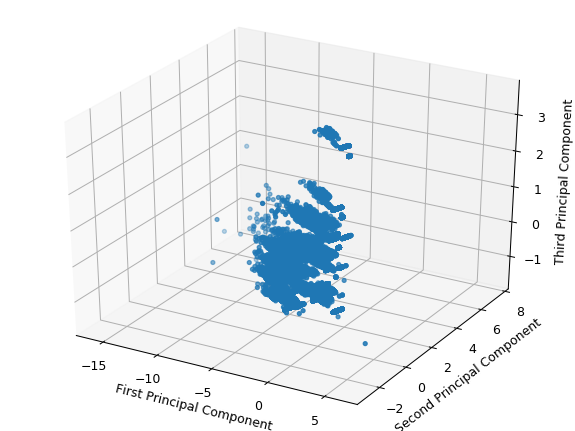

Text(0.5, 0, 'Third Principal Component')

In [14]:
#plot
%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs=features_new_pandas.PC1,ys=features_new_pandas.PC2,zs=features_new_pandas.PC3,s=10)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

## Determine the number of clusters:

In [15]:
total_errors = []
for k in range(1,11):
    exec('clusters = H2OKMeansEstimator(standardize=True,k='+str(k)+', seed=12345)')
    clusters.train(x=X, training_frame=frame_new)
    total_errors.append(clusters.tot_withinss())

kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%


## Figure 3: The number of clusters, k, vs. the total within-cluster error

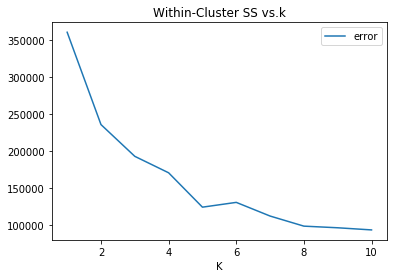

In [16]:
%matplotlib inline
k = [k for k in range(1, 11)]
plt.figure()
plt.plot(k, total_errors,label='error')
plt.legend(loc='upper right')
plt.xlabel('K')
#plt.ylabel('Within-Cluster Error')
plt.title('Within-Cluster SS vs.k')
plt.show()
 

In [17]:
# train k-means cluster model
# print summary
clusters = H2OKMeansEstimator(standardize=True, k=5, seed=12345)
clusters.train(x=X, training_frame=frame_new)
print(clusters)

kmeans Model Build progress: |████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1556922354866_13


ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 124357.85712589504
Total Sum of Square Error to Grand Mean: 360507.00198092224
Between Cluster Sum of Square Error: 236149.1448550272
Centroid Statistics: 


,centroid,size,within_cluster_sum_of_squares
,1.0,13781.0,22114.0504702
,2.0,15500.0,35033.1709213
,3.0,1102.0,9139.1128463
,4.0,17759.0,38676.1489466
,5.0,15978.0,19395.3739414


Scoring History: 


,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
,2019-05-03 18:27:29,0.041 sec,0.0,nan,nan
,2019-05-03 18:27:29,0.173 sec,1.0,64120.0,428446.1896721
,2019-05-03 18:27:29,0.179 sec,2.0,7103.0,204332.9291085
,2019-05-03 18:27:29,0.185 sec,3.0,2489.0,197692.4688908
,2019-05-03 18:27:29,0.191 sec,4.0,2092.0,194592.2827328
,2019-05-03 18:27:29,0.197 sec,5.0,8641.0,180661.2030069
,2019-05-03 18:27:29,0.203 sec,6.0,4593.0,162486.2097207
,2019-05-03 18:27:29,0.213 sec,7.0,2473.0,157639.9075596
,2019-05-03 18:27:29,0.221 sec,8.0,2061.0,154574.5218764
,2019-05-03 18:27:29,0.229 sec,9.0,3642.0,150019.6387766


## Confirm the number of clusters:


In [18]:
labels = clusters.predict(frame_new)
labeled_frame = features_new.cbind(labels)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


## Figure 4: The first three principal components of the training data without outliers colored by cluster label.

<IPython.core.display.Javascript object>


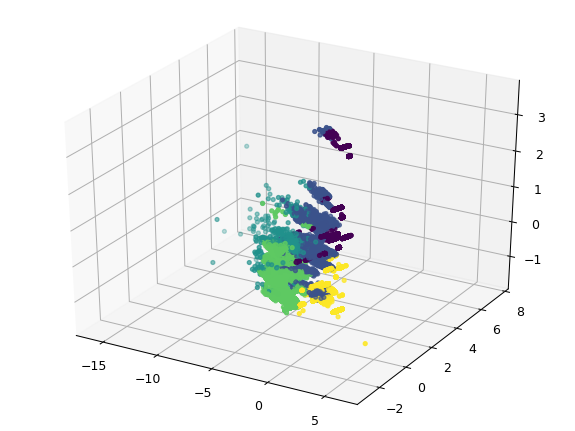

In [19]:
labeled_frame_pandas = labeled_frame.as_data_frame()
%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs=labeled_frame_pandas.PC1,ys=labeled_frame_pandas.PC2,zs=labeled_frame_pandas.PC3,s=10,c=labeled_frame_pandas.predict)

## Profile clusters:


In [20]:
# join cluster labels to data for further analysis
labeled_frame_new = frame_new.cbind(labels)

## Figure 5: Centroids for k-means clusters in the training data.


In [21]:
# profile clusters by means
grouped = labeled_frame_new.group_by(by=['predict'])
means = grouped.mean(col=X).get_frame()
print(means)

predict,mean_offervalue,mean_avg_category_quantity,mean_avg_category_amount,mean_exact_item_bought,mean_month,mean_week,mean_day
0,1.98868,0.0121355,0.0299874,0.0124084,0.722154,5.40432,22.5429
1,1.27502,1.31836,4.62313,0.996452,0.646387,5.39645,24.2474
2,1.12364,3.33443,10.3454,0.991833,0.853902,6.23593,23.1733
3,1.09815,0.939881,2.91457,0.719917,0.847232,4.17991,5.36753
4,0.787661,0.21914,0.543999,0.184691,0.10527,3.29234,25.8372


#### centroids 0: Relatively have higher offer value, have lower probablility to purchase，purchased happened on medium in month week, day（latter on that month），have lower value in avg_category_quantity，avg_category_amount
#### centroids 1: Relatively have medium offer value, more likely to do purchase， with medium category_quantity, category_amount, purchased during medium month and week, on higher value of day（latter on that month）
#### centroids 2: Relatively have medium in offer value, have much higher avg_category_quantity and avg_category_amount，more likely to purchase during higher value of month and week on higher value of day（latter on that month）
#### centroids 3: Relatively have medium in offer value, have medium avg_category_quantity and avg_category_amount，likely to purchase，purchase happened during higher value of month and medium value of week on lower value of day（earlier on that month）
#### centroids 4: Relatively have lower in offer value, have lower avg_category_quantity and avg_category_amount，less likely to purchase，purchase happened in during lower value of month（earlier） and medium value of week on higher value of day（latter on that month）

In [22]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_bcb4 closed.


## Bonus

#### We might see that the expected effect is that it not only shows the degree the 2 outliers will increase the within-cluster error of the model，but also shows that that the difference of the within-cluster error will decrease as the centroid number (K) increase.